# Threshold KNN‑Shapley Explainer  
*A hands‑on guide*

This notebook shows how to use the *Threshold KNN‑Shapley Explainer* to attribute predictions to individual training points when you the neighbourhood is restriced by a distance threshold **tau / τ**.  
It complements the basic and weighted KNN explainers and is ideal for situations where “local” influence scores in dense data regions are desired.

---

## Table of Contents
1. What problem does “threshold KNN‑Shapley” solve?
2. How is it implemented?
3. Quick‑start: explaining a scikit‑learn model  
4. Visual walkthrough on a toy dataset
5. Summary

### 1  What problem does it solve?
*Point Shapley* (sometimes called Instance Shapley) scores tell how much training point **i** sways the prediction for test point **x**.  

The threshold variant uses a distance radius **τ** instead of a fixed **k** neighbours.  
Only points with  
$$\left\lVert x_i - x_{\text{test}}\right\rVert \le \tau$$
can vote in the majority prediction inside every coalition (of training points).

Realistic use‑cases:
* Local explanation in dense clusters (far‑away outliers won't influence vote).  
* Streaming data: Future density changes effectively ignored.
* Fairness audits: Checks if points within a small radius are dominating a decision.

### 2  How does the implementation work?
```python
from shapiq_student.threshold_knn_explainer import ThresholdKNNExplainer
help(ThresholdKNNExplainer)

* Exact Shapley: enumerates *n_train !* permutations, although only feasible up to around 10 points.  
* Only the points inside **τ** count for the majority vote. If no one is inside, payoff is set to 0.
* Returns an *InteractionValues* object with: *values.shape == (n_train,)  &  index == 'SV'*.

### 3  Quick‑start on Iris
Below, nine training points from the Iris dataset so that the exact permutation‑based algorithm is still tractable (9 ! ≈ 3.6 × 10⁵).
This keeps the demo snappy while showing the full, exact computation.

In [1]:
from sklearn.datasets import load_iris
from sklearn.neighbors import RadiusNeighborsClassifier
import numpy as np

X, y = load_iris(return_X_y=True)

# Use the first 9 rows (3 from each class) so n_train! is manageable.
idx_small = np.r_[0:3, 50:53, 100:103]
X_small, y_small = X[idx_small], y[idx_small]

tau = 0.8
clf = RadiusNeighborsClassifier(radius=tau)
clf.fit(X_small, y_small)

x_test = X_small[0] + 0.05  # small perturbation of the first point

from shapiq_student.threshold_knn_explainer import ThresholdKNNExplainer

expl = ThresholdKNNExplainer(
    model=clf,
    data=X_small,
    labels=y_small,
    tau=tau,           # Matches the classifier's radius
    class_index=None,  # If none, explain the model's predicted class
)
shap = expl.explain(x_test)

print("Shapley values (length = n_train = 9):")
print(np.round(shap.values, 3))
print("\nSum of SVs:", shap.values.sum())

Shapley values (length = n_train = 9):
[0.333 0.333 0.333 0.    0.    0.    0.    0.    0.   ]

Sum of SVs: 1.0


### 4  Visual walkthrough on a 2‑D toy set
A minimal example that can be visualized on a canvas.

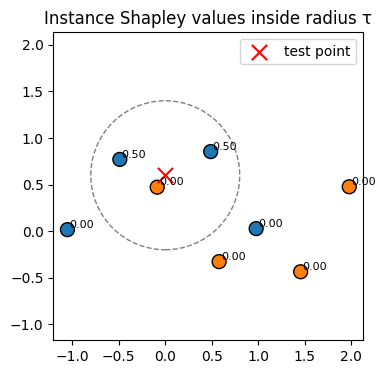

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X2, y2 = make_moons(n_samples=8, noise=0.05, random_state=42)
tau = 0.8
rc = RadiusNeighborsClassifier(radius=tau).fit(X2, y2)

x_star = np.array([[0.0, 0.6]])
expl2 = ThresholdKNNExplainer(model=rc, data=X2, labels=y2, tau=tau)
sv = expl2.explain(x_star).values

# --- plot
plt.figure(figsize=(4,4))
colors = np.array(["tab:blue", "tab:orange"])
plt.scatter(X2[:,0], X2[:,1], c=colors[y2], s=100, edgecolor="k")
plt.scatter(*x_star[0], c="red", marker="x", s=120, label="test point")
circle = plt.Circle(x_star[0], tau, color="grey", fill=False, linestyle="--")
plt.gca().add_patch(circle)

for i, (x_i, sv_i) in enumerate(zip(X2, sv)):
    plt.text(x_i[0]+0.02, x_i[1]+0.02, f"{sv_i:.2f}", fontsize=8)

plt.title("Instance Shapley values inside radius τ")
plt.legend()
plt.axis("equal")
plt.show()

The blue dots vote for the test point’s class, while the orange dots vote against it.  
As this is concerns a threshold, only the three dots inside the dashed radius of **τ = 0.8** are seen.  
The two blue points raise the vote to the target class, so each gets a positive Shapley share of **0.5**.  
The lone orange neighbour never secures the majority, so its Shapley value is **0**.  

### 5 Summary


* **What was built** – A Threshold KNN‑Shapley explainer that attributes each training point’s influence on a prediction, but only counts neighbours within a distance **τ**.  
* **How it works** – Enumerates all permutations of the training set (exact Shapley) and evaluates a 0/1 payoff based on the majority vote inside the radius.  
* **Key takeaway** – Points inside τ share the Shapley credit; points outside get zero. Adjusting τ zooms the explanation lens in or out.